In [1]:
# downloading dataset from https://archive.materialscloud.org/record/2020.110

'''!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz
!gunzip -k methane.extxyz.gz'''

'!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz\n!gunzip -k methane.extxyz.gz'

In [2]:
import numpy as np
import ase.io
import tqdm
from nice.blocks import *
from nice.utilities import *
from matplotlib import pyplot as plt
import torch
from torch import nn
import sys
sys.path.append('./code/')
from code_pytorch import *
from utilities import *

In [3]:
HARTREE_TO_EV = 27.211386245988
LAMBDA_MAX = 5
HYPERS = {
    'interaction_cutoff': 6.3,
    'max_radial': 5,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
}
train_subset = '0:1000'
test_subset = '1000:1500'
DEVICE = 'cuda'

In [4]:
train_structures = ase.io.read('methane.extxyz', index=train_subset)

test_structures = ase.io.read('methane.extxyz', index=test_subset)

all_species = get_all_species(train_structures + test_structures)

train_coefficients = get_spherical_expansion(train_structures, HYPERS,
                                             all_species, split_by_central_specie = False)

test_coefficients = get_spherical_expansion(test_structures, HYPERS,
                                            all_species, split_by_central_specie = False)

scaler = InitialScaler(mode='signal integral', individually=True)
scaler.fit(train_coefficients[0:500])

train_coefficients = scaler.transform(train_coefficients)
test_coefficients = scaler.transform(test_coefficients)

print(train_coefficients.shape)
print(test_coefficients.shape)

100%|██████████| 5/5 [00:00<00:00, 60.43it/s]

(5000, 10, 6, 11)
(2500, 10, 6, 11)


In [5]:
train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV

mean_e = np.mean(train_energies)
train_energies = train_energies - mean_e
test_energies = test_energies - mean_e

train_energies = torch.FloatTensor(train_energies).to(DEVICE)
test_energies = torch.FloatTensor(test_energies).to(DEVICE)

In [6]:
def convert_to_torch(coefficients, device):
    result = {}
    for lambd in range(coefficients.shape[2]):
        result[lambd] = torch.FloatTensor(coefficients[:, :, lambd, : 2 * lambd + 1]).to(device)        
    return result

train_coefficients = convert_to_torch(train_coefficients, DEVICE)
test_coefficients = convert_to_torch(test_coefficients, DEVICE)

for key in train_coefficients.keys():
    print(train_coefficients[key].shape)

torch.Size([5000, 10, 1])
torch.Size([5000, 10, 3])
torch.Size([5000, 10, 5])
torch.Size([5000, 10, 7])
torch.Size([5000, 10, 9])
torch.Size([5000, 10, 11])


In [7]:
def get_loss(predictions, targets):
    delta = predictions - targets
    return torch.mean(delta * delta)

def get_mae(first, second):
    return np.mean(np.abs(first - second))

def get_rmse(first, second):
    delta = first - second
    return np.sqrt(np.mean(delta * delta))

class Model(torch.nn.Module):
    def __init__(self, input_lambda_max):
        super(Model, self).__init__()
        clebsch = nice.clebsch_gordan.ClebschGordan(input_lambda_max)
        self.clebsch_combining = ClebschCombining(clebsch.precomputed_, 0)
        self.sequential = nn.Sequential(nn.Linear(600, 100), nn.Tanh(), nn.Linear(100, 1))
        
    def forward(self, X):
        X = self.clebsch_combining(X, X)[0].squeeze()        
        return {'predictions' : self.sequential(X)}

In [8]:
model = Model(LAMBDA_MAX)
result = model(train_coefficients)
print(type(result))
print(result['predictions'].shape)

<class 'dict'>
torch.Size([5000, 1])


In [9]:
models = {}
for key in all_species:
    models[str(key)] = Model(LAMBDA_MAX)
    

In [10]:
atomistic = Atomistic(models).to(DEVICE)
optim = torch.optim.Adam(atomistic.parameters())
train_structural_indices = get_structural_indices(train_structures)
test_structural_indices = get_structural_indices(test_structures)


train_central_species = get_central_species(train_structures)
test_central_species = get_central_species(test_structures)

train_atomic = copy.deepcopy(train_coefficients)
train_atomic['central_species'] = train_central_species

test_atomic = copy.deepcopy(test_coefficients)
test_atomic['central_species'] = test_central_species

train_struc = {'energies' : train_energies}
test_struc = {'energies' : test_energies}

BATCH_SIZE = 500
for epoch_num in range(1000):
    train_predictions = []
    for atomic_batch, structural_batch, b_struc_ind in iterate_minibatches(train_atomic, train_struc,
                                                  train_structural_indices, BATCH_SIZE):
        central_species_now = atomic_batch['central_species']
        coef_now = atomic_batch
        del coef_now['central_species']
        
        energies_now = structural_batch['energies']
        
        predictions = atomistic(coef_now, central_species_now, b_struc_ind)['predictions'].squeeze()
        train_predictions.append(predictions.data.cpu().numpy())       
        loss = get_loss(predictions, energies_now)
        loss.backward()
        optim.step()
        optim.zero_grad()
    
    train_predictions = np.concatenate(train_predictions, axis = 0)
    if epoch_num % 100 == 0:
        print("train mae: ", get_mae(train_predictions, train_energies.data.cpu().numpy()))
        print("train rmse: ", get_rmse(train_predictions, train_energies.data.cpu().numpy()))
        
    test_predictions = []
    for atomic_batch, structural_batch, b_struc_ind in iterate_minibatches(test_atomic, test_struc,
                                                   test_structural_indices, BATCH_SIZE):
        central_species_now =  atomic_batch['central_species']
        coef_now = atomic_batch
        del coef_now['central_species']
        
        energies_now = structural_batch['energies']
        predictions = atomistic(coef_now, central_species_now, b_struc_ind)['predictions'].squeeze()
        test_predictions.append(predictions.data.cpu().numpy())
    test_predictions = np.concatenate(test_predictions, axis = 0)
    if epoch_num % 100 == 0:
        print("test mae: ", get_mae(test_predictions, test_energies.data.cpu().numpy()))
        print("test rmse: ", get_rmse(test_predictions, test_energies.data.cpu().numpy()))
    

train mae:  1.9896358
train rmse:  3.0072358
test mae:  2.1997788
test rmse:  3.488912
train mae:  0.58064646
train rmse:  0.8541137
test mae:  0.65635014
test rmse:  1.1821108
train mae:  0.46290264
train rmse:  0.66928464
test mae:  0.5521444
test rmse:  0.99686927
train mae:  0.4193727
train rmse:  0.5919469
test mae:  0.5033183
test rmse:  0.9036031
train mae:  0.39146253
train rmse:  0.5421981
test mae:  0.47421333
test rmse:  0.8397839
train mae:  0.36758265
train rmse:  0.5025582
test mae:  0.4501499
test rmse:  0.7895865
train mae:  0.34736097
train rmse:  0.47018307
test mae:  0.42962158
test rmse:  0.7489019
train mae:  0.3315078
train rmse:  0.44605654
test mae:  0.4157985
test rmse:  0.7180431
train mae:  0.31977832
train rmse:  0.42877603
test mae:  0.40633568
test rmse:  0.6955956
train mae:  0.3113336
train rmse:  0.41614726
test mae:  0.39949113
test rmse:  0.67951304


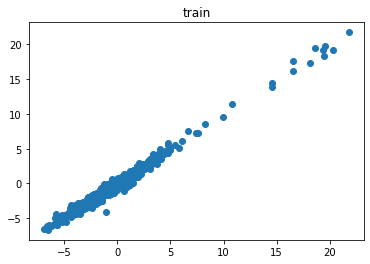

train rmse 0.40654248
train mae:  0.30510345


In [11]:
plt.plot(train_energies.data.cpu().numpy(), train_predictions, 'o')
plt.title("train")
plt.show()
print("train rmse", get_rmse(train_energies.data.cpu().numpy(), train_predictions))
print("train mae: ", get_mae(train_energies.data.cpu().numpy(), train_predictions))



test rmse 0.6682584
test mae:  0.39368713


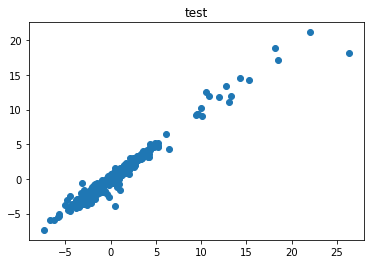

In [12]:
plt.plot(test_energies.data.cpu().numpy(), test_predictions, 'o')
plt.title("test")

print("test rmse", get_rmse(test_energies.data.cpu().numpy(), test_predictions))
print("test mae: ", get_mae(test_energies.data.cpu().numpy(), test_predictions))
plt.show()

In [13]:
for key in coef_now.keys():
    print(key, coef_now[key].shape)
    
print(predictions.requires_grad)
print(coef_now[0].requires_grad)
coef_now[0].requires_grad = True
predictions = atomistic(coef_now, central_species_now, b_struc_ind)['predictions'].squeeze()


print(predictions.shape)
derivatives = torch.autograd.grad(outputs = predictions, inputs = coef_now[0], 
                                  grad_outputs = torch.ones(predictions.shape, device = DEVICE))
print(derivatives[0].shape)

0 torch.Size([2500, 10, 1])
1 torch.Size([2500, 10, 3])
2 torch.Size([2500, 10, 5])
3 torch.Size([2500, 10, 7])
4 torch.Size([2500, 10, 9])
5 torch.Size([2500, 10, 11])
True
False
torch.Size([500])
torch.Size([2500, 10, 1])


In [17]:
a = torch.FloatTensor([[1, 2], [3, 4], [5, 6]])
print(a)
index = torch.LongTensor([0, 0, 2, 1, 1, 1])
result = torch.index_select(a, 0, index)
print(result)

tensor([[1., 2.],
        [3., 4.],
        [5., 6.]])
tensor([[1., 2.],
        [1., 2.],
        [5., 6.],
        [3., 4.],
        [3., 4.],
        [3., 4.]])


In [26]:
index_small = '0:100'
structures = ase.io.read('methane.extxyz', index=index_small)
coefficients = get_spherical_expansion(structures, HYPERS,
                                             all_species, split_by_central_specie = False)
coefficients = scaler.transform(coefficients)
coefficients = convert_to_torch(coefficients, DEVICE)

energies =  [structure.info['energy'] for structure in structures]
energies = np.array(energies) * HARTREE_TO_EV
energies = energies - mean_e


structural_indices = get_structural_indices(structures)
central_species = get_central_species(structures)

for key in coefficients.keys():
    print(key, coefficients[key].shape)
print(energies.shape)
print(structural_indices.shape)
print(central_species.shape)

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

0 torch.Size([500, 10, 1])
1 torch.Size([500, 10, 3])
2 torch.Size([500, 10, 5])
3 torch.Size([500, 10, 7])
4 torch.Size([500, 10, 9])
5 torch.Size([500, 10, 11])
(100,)
(500,)
(500,)


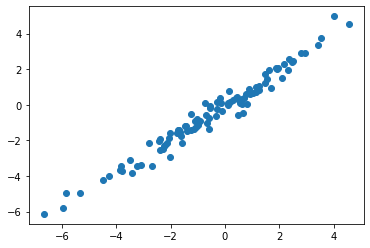

In [27]:
predictions = atomistic(coefficients, central_species,
                        structural_indices)['predictions'].squeeze().data.cpu().numpy()

plt.plot(energies, predictions, 'o')
plt.show()